In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.utils.KerasCallbacks import get_callbacks

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

MODEL_PATH = os.path.join('models', EXPERIMENT, timestemp)
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,timestemp)
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,timestemp)
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,timestemp)


# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize

DIM = [8, 64, 64] # network input params for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 3 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-11 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = False
AUGMENT_PHASES_RANGE = (-3,3)
SHUFFLE = True
RESAMPLE = True
SCALER = 'MinMax' # MinMax, Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 12
SMOOTHING_LOWER_BORDER = 1
SMOOTHING_UPPER_BORDER = 5
SMOOTHING_WEIGHT_CORRECT = 10

# Data paths
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'



Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-02-24 16:02:59,843 INFO -------------------- Start --------------------
2021-02-24 16:02:59,843 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-02-24 16:02:59,843 INFO Log file: ./logs/temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug.log
2021-02-24 16:02:59,844 INFO Log level for console: INFO
2021-02-24 16:02:59,845 INFO Is built with tensorflow: True
2021-02-24 16:02:59,908 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2021-02-24 16:03:00,550 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {

{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug', 'MODEL_PATH': 'models/temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug/2021-02-24_16_02', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug/2021-02-24_16_02', 'CONFIG_PATH': 'reports/configs/temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug/2021-02-24_16_02', 'HISTORY_PATH': 'reports/history/temp/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug/2021-02-24_16_02', 'BATCHSIZE': 8, 'GENERATOR_WORKER': 8, 'DIM': [8, 64, 64], 'T_SHAPE': 36, 'SPACING': [8, 3, 3], 'DEPTH': 3, 'FILTERS': 32, 'M_POOL': [1, 2, 2], 'F_SIZE': [3, 3, 3], 'BN_FIRST': False, 'BATCH_NORMALISATION': True, 'PAD': 'same', 'KERNEL_INIT': 'he_normal', 'OPTIMIZER': 'adam', 'AC

In [2]:
# zip the phase files in the following structure:
#[[patient1_phase1, patient1_phase2, patient1_phase3, patient1_phase4, patient1_phase5],[patient2_phase1...] ...]

images = sorted(glob.glob('/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/*clean.nrrd'))
# add randomness, but idempotent, this issimilar to shuffle but we could leave some data out
images = random.sample(images, len(images))
print(len(images))

278


In [3]:
images[83]

'/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/0000-K61NJJ2D_2007-05-29_volume_clean.nrrd'

In [4]:
# check if we find each patient in the corresponding dataframe
import re
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]


for x in images:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))

In [5]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [6]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(images[:220], images[:220], config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(images[220:], images[220:] , config=val_config)

2021-02-24 16:03:00,948 INFO Create DataGenerator
2021-02-24 16:03:00,950 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 220 
 Augment: True 
 Thread workers: 8
2021-02-24 16:03:00,950 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-02-24 16:03:00,964 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-02-24 16:03:00,964 INFO Temporal phase augmentation: False
2021-02-24 16:03:00,965 INFO Create DataGenerator
2021-02-24 16:03:00,965 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 58 
 Augment: False 
 Thread workers: 8
2021-02-24 16:03:00,966 INFO No augmentation
2021-02-24 16:03:00,979 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-02-24 16:03:00,979 INFO Temporal phase augmentation: False


In [11]:
# visualise one batch
@interact_manual
def select_image_in_batch(batch = (0,len(validation_generator), 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_=True):
    
    import time
    global inputs, outputs, gt_len
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = validation_generator.__getitem__(batch)
    outputs, gt_len_msk = np.split(outputs, indices_or_sections=2,axis=1)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_:
    
        selected_input = inputs[im]
        selected_output = outputs[im][0]
        selected_gtlen = int(np.sum((gt_len_msk[im,0,:,0])))
        logging.info('GT length: {}'.format(selected_gtlen))

        logging.debug('pad: \n{}'.format(selected_output))
        
        f, axs = plt.subplots(1,2,figsize=(5,5))
        i = 0
        temp_y = selected_output
        ind_gt = np.argmax(temp_y[:selected_gtlen,:], axis=0)
        axs[0].title.set_text('y')
        axs[0].set_yticks(ind_gt, minor=False)
        axs[0].set_xticks([0,1,2,3,4], minor=False)
        axs[0].set_xticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto')
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
        
        list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))

        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=3, description='batch', max=7), IntSlider(value=3, description='im', max…

In [10]:
# test if all batches are processable
"""for b in range(len(validation_generator)):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)"""

'for b in range(len(validation_generator)):\n    print(b)\n    for im in range(BATCHSIZE):\n        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)'

In [35]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

(None, 8, 8, 8, 256)
(None, 256)
(None, 36, 256)
encoder
(None, 36, 256)
bi LSTM
(None, 36, 64)
conv1d 32 3,1
(None, 36, 64)


In [23]:
model.summary(line_length=150)

Model: "PhaseRegressionModel"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_5 (InputLayer)                             [(None, 36, 8, 64, 64, 1)]       0                                                                   
______________________________________________________________________________________________________________________________________________________
tf_op_layer_unstack_8 (TensorFlowOpLayer)        [(None, 36, 64, 64, 1), (None, 3 0                 input_5[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv_encoder_9 (ConvEncoder)                     ((None, 36, 8, 

In [36]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    #steps_per_epoch=len(batch_generator),
    validation_data=validation_generator,
    #validation_steps=len(validation_generator),
    epochs=200,
    #callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    #workers=2,
    use_multiprocessing=False,
    verbose=1)

Epoch 1/200
(None, None, None, None)
(None, None, None)
(None, 36, 5)
(None, None, None)
y_len shape: (None,)
gt_idx shape: (None, None)
pred_idx shape: (None, 5)
filled shape: (None, None)
(3,)
(None, None, None, None)
(None, None, None)
(None, 36, 5)
(None, None, None)
y_len shape: (None,)
gt_idx shape: (None, None)
pred_idx shape: (None, 5)
filled shape: (None, None)
(3,)
(None, None, None, None)
(None, None, None)
(None, 36, 5)
(None, None, None)
y_len shape: (None,)
gt_idx shape: (None, None)
pred_idx shape: (None, 5)
filled shape: (None, None)
(3,)
(None, None, None, None)
(None, None, None)
(None, 36, 5)
(None, None, None)
y_len shape: (None,)
gt_idx shape: (None, None)
pred_idx shape: (None, 5)
filled shape: (None, None)
(3,)
27/27 [==============================] - ETA: 0s - loss: 1.6972 - meandiff: 15.3481(None, None, None, None)
(None, None, None)
(None, 36, 5)
(None, None, None)
y_len shape: (None,)
gt_idx shape: (None, None)
pred_idx shape: (None, 5)
filled shape: (None, N

KeyboardInterrupt: 

In [14]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [50]:
temp = np.array([23, 17, 24, 18])
print(temp.shape)
empty = np.ones((4,36,5))
print(empty.shape)
second = empty[:]
second[:,0,0] = temp
np.stack([empty, second], axis=1).shape

(4,)
(4, 36, 5)


(4, 2, 36, 5)

In [13]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

[[23  4  9 13 21]
 [ 0  5 10 15 17]
 [24  4  8 13 20]
 [ 0  6 12 17 18]]
[23 17 24 18]


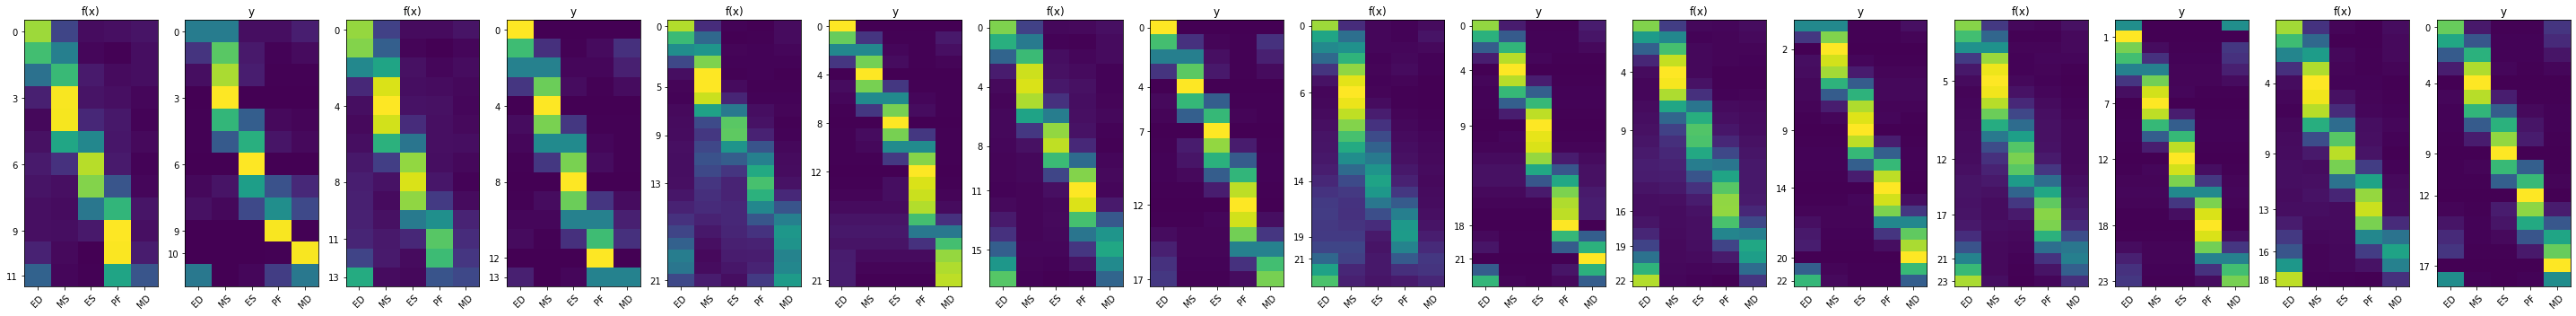

In [39]:
from src.visualization.Visualize import show_phases
_ = show_phases(outputs,pred)

In [27]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
score_fn((outputs,gt_len), outputs, batchsize=BATCHSIZE).numpy()

tf.Tensor(
[[25]
 [25]
 [25]
 [25]
 [25]
 [20]
 [20]
 [16]], shape=(8, 1), dtype=int32)
tf.Tensor(
[[11]
 [11]
 [11]
 [11]
 [11]
 [16]
 [16]
 [20]], shape=(8, 1), dtype=int32)
(5, 2)
tf.Tensor([24  5 10 15 20], shape=(5,), dtype=int64)
tf.Tensor([24  5 10 15 20], shape=(5,), dtype=int64)
(5, 2)
tf.Tensor([24  4  8 13 20], shape=(5,), dtype=int64)
tf.Tensor([24  4  8 13 20], shape=(5,), dtype=int64)
(5, 2)
tf.Tensor([ 0  5 10 13 21], shape=(5,), dtype=int64)
tf.Tensor([ 0  5 10 13 21], shape=(5,), dtype=int64)
(5, 2)
tf.Tensor([24  3  6 11 19], shape=(5,), dtype=int64)
tf.Tensor([24  3  6 11 19], shape=(5,), dtype=int64)
(5, 2)
tf.Tensor([23  5 10 15 21], shape=(5,), dtype=int64)
tf.Tensor([23  5 10 15 21], shape=(5,), dtype=int64)
(5, 2)
tf.Tensor([19  3  7 11 14], shape=(5,), dtype=int64)
tf.Tensor([19  3  7 11 14], shape=(5,), dtype=int64)
(5, 2)
tf.Tensor([19  5 10 14 17], shape=(5,), dtype=int64)
tf.Tensor([19  5 10 14 17], shape=(5,), dtype=int64)
(5, 2)
tf.Tensor([ 0  4  7 11 13]

array([0., 0., 0., 0., 0.], dtype=float32)

In [26]:
# calculate the meandiff score for all batches
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p, batchsize=BATCHSIZE))
scores

[<tf.Tensor: shape=(), dtype=float32, numpy=13.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=27.6>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.4>,
 <tf.Tensor: shape=(), dtype=float32, numpy=12.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.6>,
 <tf.Tensor: shape=(), dtype=float32, numpy=15.2>,
 <tf.Tensor: shape=(), dtype=float32, numpy=17.8>]

In [27]:
tf.reduce_mean(scores).numpy()

14.314285

# Generator tests

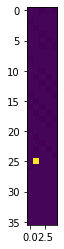

In [9]:
temp = outputs[2][:]
plt.imshow(temp)

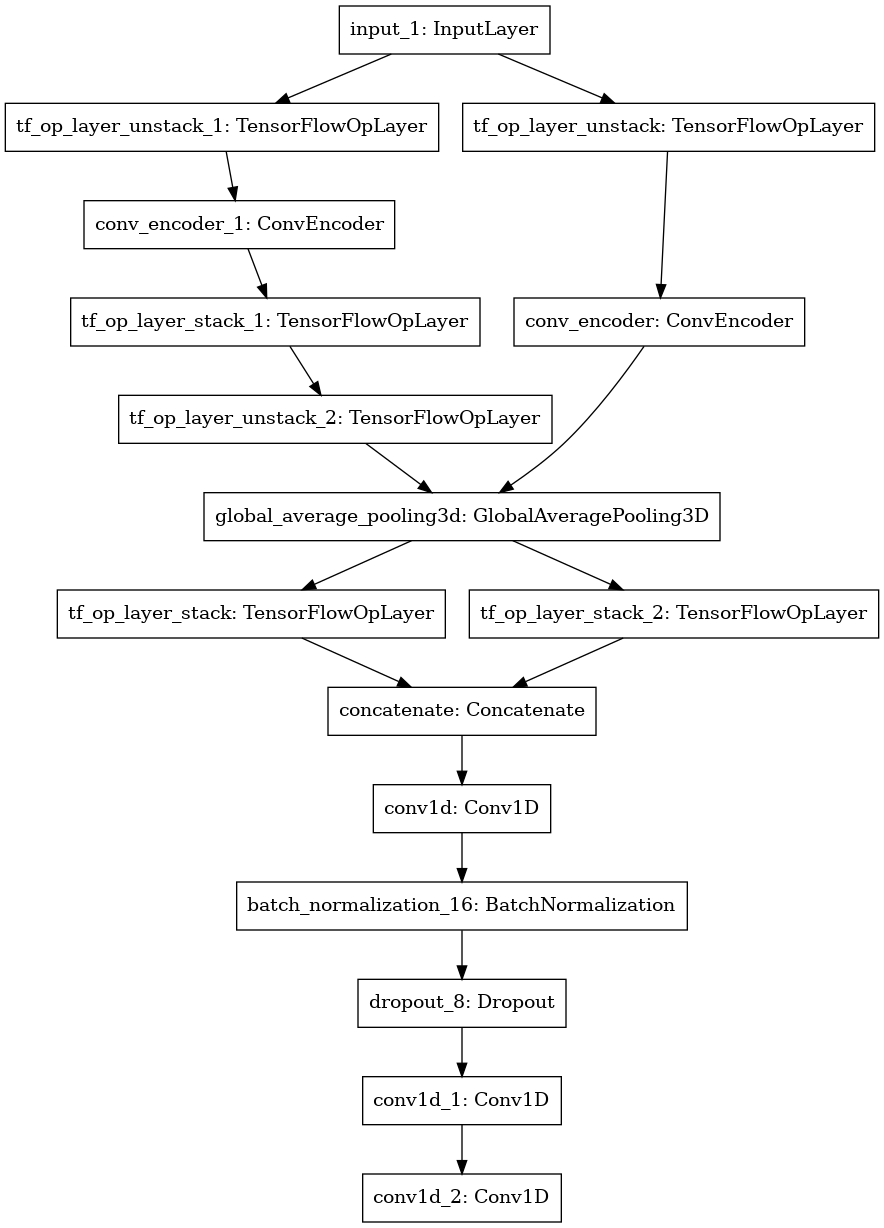

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [18]:
def meandiff_( y_true, y_pred, batchsize=4):

    """
    Average over the batches
    the sum of the absolute difference between two arrays
    y_true and y_pred are one-hot vectors with the following shape
    batchsize * timesteps * phase classes
    e.g.: 4 * 36 * 5
    First for gt and pred:
    - get the timesteps per phase with the highest probability
    - get the absolute difference between gt and pred
    (- later we can slice each patient by the max value in the corresponding gt indices)
    - sum the diff per entity
    - calc the mean over all examples

    Parameters
    ----------
    y_true :
    y_pred :

    Returns tf.float32 scalar
    -------

    """

    score = 0
    y_true = tf.cast(tf.convert_to_tensor(y_true), tf.float32)
    y_pred = tf.cast(tf.convert_to_tensor(y_pred), tf.float32)

    gt_idxs = tf.math.argmax(y_true, axis=1)
    gt_max = tf.cast(tf.reduce_max(gt_idxs, axis=1), tf.int32)
    padded_pred = []
    padded_gt = []

    msk = tf.stack([
        tf.pad(tf.ones((gt_max[i],5)), ((0,36-gt_max[i]),(0,0)))
        for i in range(batchsize)])
    #msk = tf.zeros_like(y_pred)
    #msk[:,:tf.reduce_max(gt_max), :] = 1

    temp_pred = y_pred * msk
    temp_gt = y_true * msk

    #y_pred = tf.unstack(y_pred, axis=0)
    #y_true = tf.unstack(y_true, axis=0)

    """def pad_to_size(p, max_id):
        to_pad = p.shape[0] - max_id
        print(p.shape[0])
        print(max_id)
        print(to_pad)
        return tf.pad(p, [[0,to_pad],[0,0]])

    padded_pred = list(map(lambda x : pad_to_size(x[0], x[1]), zip(y_pred, gt_max)))
    padded_gt = list(map(lambda x: pad_to_size(x[0], x[1]), zip(y_true, gt_max)))"""

    """for idx in tf.range(y_pred.shape[0]):
        max_idx = gt_max[idx]
        p = y_pred[idx][:max_idx, :]
        to_pad = y_pred.shape[1] - max_idx
        padded_pred.append(tf.pad(p, [[0,to_pad],[0,0]]))

        y = y_true[idx][:max_idx, :]
        padded_gt.append(tf.pad(y, [[0, to_pad], [0, 0]]))"""

    #temp_pred = tf.stack(padded_pred, axis=0)
    #temp_gt = tf.stack(padded_gt, axis=0)

    gt_idx = tf.math.argmax(temp_gt, axis=1)
    pred_idx = tf.math.argmax(temp_pred, axis=1)

    diffs = tf.stack([tf.stack(get_min_dist_for_list(gt_idx[i],pred_idx[i], batchsize)) for i in range(batchsize)])

    #diffs = tf.math.subtract(gt_idx, pred_idx)
    #print('substract: {}'.format(diffs.numpy()))
    #diffs = tf.abs(diffs)
    #print('abs: {}'.format(diffs.numpy()))
    diffs = tf.cast(tf.reduce_sum(diffs, axis=1),tf.float32)
    #print('sum: {}'.format(diffs.numpy()))
    diffs = tf.reduce_mean(diffs)

    return diffs


def get_min_dist_for_list(lst_a,lst_b, batchsize):
    length = tf.reduce_max(tf.stack([lst_a, lst_b]))
    #print(length)
    #length = max(max(lst_a), max(lst_b)) + 1
    return [get_min_distance(lst_a[i],lst_b[i],length) for i in range(batchsize)]

def get_min_distance(a, b, mod):
    #assert(mod>(tf.reduce_max(a,b))), 'a: {}, b: {}, mod:{}, '.format(a,b,mod)

    decr_counter = 0
    incr_counter = 0

    smaller = tf.reduce_min(tf.stack([a, b]))
    bigger = tf.reduce_max(tf.stack([a, b]))

    i1 = bigger
    while (i1 != smaller):
        decr_counter = decr_counter + 1
        i1 = i1 - 1

    i1 = bigger
    while (i1 != smaller):
        incr_counter = incr_counter + 1
        i1 = tf.math.mod((i1 + 1), mod)
        #i1 =  % mod

    return tf.reduce_min(tf.stack([decr_counter, incr_counter]))

In [22]:
lst = [1,2,3,4,5,6,7,8,9]
first = lst[3:]
first.extend(lst[:3])
first

[4, 5, 6, 7, 8, 9, 1, 2, 3]

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)